# BOOK RECOMMENDATION SYSTEM

In [45]:
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.vq import kmeans, vq
from difflib import get_close_matches
from matplotlib.lines import Line2D

In [ ]:
path = kagglehub.dataset_download("jealousleopard/goodreadsbooks")
df = pd.read_csv(path + '/books.csv', on_bad_lines='skip')
df.head()

In [2]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


In [3]:
# check if any null values
df.isnull().sum()

,0
bookID,0
title,0
authors,0
average_rating,0
isbn,0
isbn13,0
language_code,0
num_pages,0
ratings_count,0
text_reviews_count,0


In [4]:
df.columns.tolist()

['bookID',
 'title',
 'authors',
 'average_rating',
 'isbn',
 'isbn13',
 'language_code',
 '  num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher']

In [39]:
# Rename the column
df = df.rename(columns={'  num_pages': 'num_pages'})

In [6]:
df.columns.tolist()

['bookID',
 'title',
 'authors',
 'average_rating',
 'isbn',
 'isbn13',
 'language_code',
 'num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher']

In [40]:
# Function to remove outliers based on thresholds
def remove_outliers(data, column, threshold):
    return data[data[column] <= threshold]

# Remove outliers for specific features
df = remove_outliers(df, 'ratings_count', 2000000)
df = remove_outliers(df, 'num_pages', 1000)
df.dropna(inplace=True)  # Remove rows with missing values

In [41]:
# Feature segregation based on average_rating
def segregate_ratings(data):
    values = []
    for val in data['average_rating']:
        if val <= 1:
            values.append("Between 0 and 1")
        elif val <= 2:
            values.append("Between 1 and 2")
        elif val <= 3:
            values.append("Between 2 and 3")
        elif val <= 4:
            values.append("Between 3 and 4")
        else:
            values.append("Between 4 and 5")
    return values

df['Ratings_Dist'] = segregate_ratings(df)

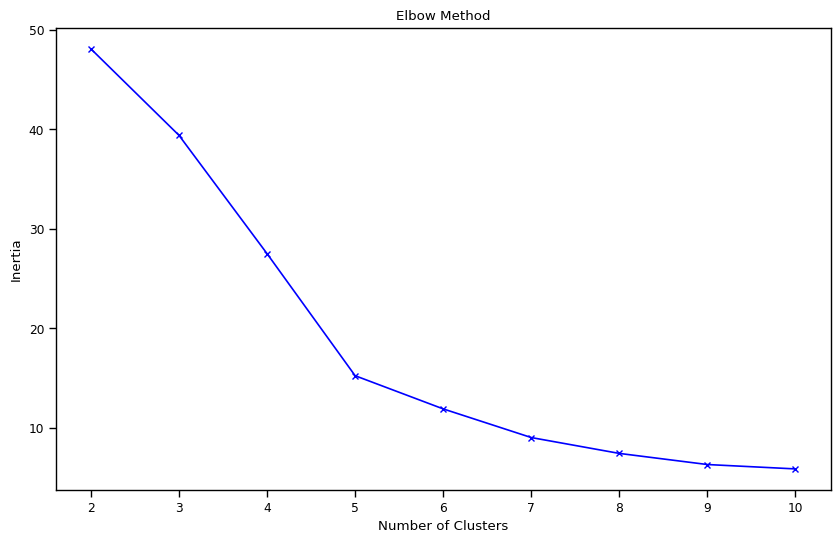

In [42]:
# Normalize numerical features
numerical_features = ['average_rating', 'ratings_count', 'num_pages']
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Prepare data for KMeans clustering
clustering_features = df[['average_rating', 'ratings_count']]
clustering_data = np.asarray([np.asarray(clustering_features['average_rating']), np.asarray(clustering_features['ratings_count'])]).T

# Elbow method to determine optimal clusters
distortions = []
for k in range(2, 11):
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(clustering_data)
    distortions.append(k_means.inertia_)

# Visualize Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), distortions, 'bx-')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [43]:
# Apply KMeans with optimal clusters
optimal_k = 5
centroids, _ = kmeans(clustering_data, optimal_k)
idx, _ = vq(clustering_data, centroids)

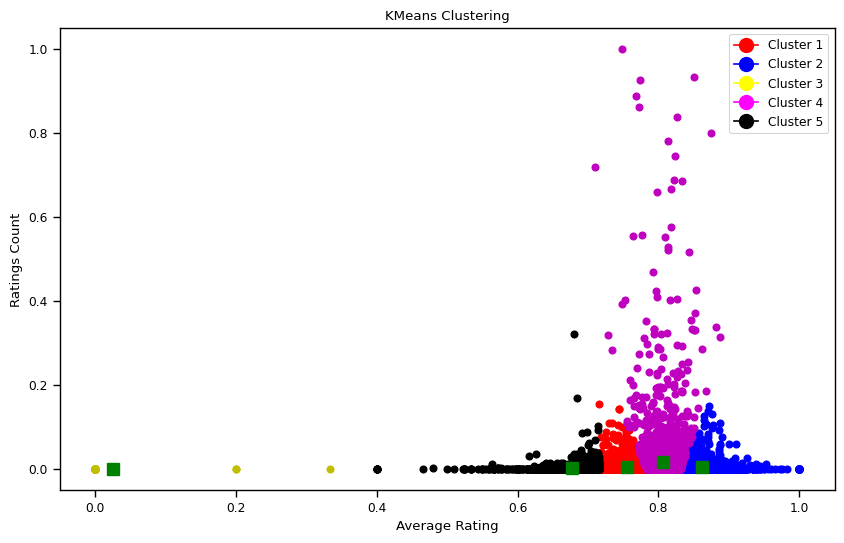

In [46]:
# Plot clusters
sns.set_context('paper')
plt.figure(figsize=(10, 6))
plt.plot(clustering_data[idx == 0, 0], clustering_data[idx == 0, 1], 'or',
         clustering_data[idx == 1, 0], clustering_data[idx == 1, 1], 'ob',
         clustering_data[idx == 2, 0], clustering_data[idx == 2, 1], 'oy',
         clustering_data[idx == 3, 0], clustering_data[idx == 3, 1], 'om',
         clustering_data[idx == 4, 0], clustering_data[idx == 4, 1], 'ok')
plt.plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=8)

# Add legend
circle1 = Line2D([0], [0], color='red', marker='o', markerfacecolor='red', markersize=10)
circle2 = Line2D([0], [0], color='blue', marker='o', markerfacecolor='blue', markersize=10)
circle3 = Line2D([0], [0], color='yellow', marker='o', markerfacecolor='yellow', markersize=10)
circle4 = Line2D([0], [0], color='magenta', marker='o', markerfacecolor='magenta', markersize=10)
circle5 = Line2D([0], [0], color='black', marker='o', markerfacecolor='black', markersize=10)
plt.legend([circle1, circle2, circle3, circle4, circle5],
           ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
           loc='best')
plt.title("KMeans Clustering")
plt.xlabel("Average Rating")
plt.ylabel("Ratings Count")
plt.show()


In [56]:
# Prepare features for nearest neighbors recommendation
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(pd.concat([df['Ratings_Dist'].str.get_dummies(sep=","), df[numerical_features]], axis=1))

recommendation_model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
recommendation_model.fit(normalized_features)
neighbor_distances, neighbor_indices = recommendation_model.kneighbors(normalized_features)

In [48]:
# Fit KNN model
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(books_features)
distance, indices = model.kneighbors(books_features)

In [58]:
# Recommendation functions
def find_book_index_by_title(title):
    matches = df[df['title'].str.contains(title, case=False, na=False)].index.tolist()
    if matches:
        return matches[0]
    else:
        raise ValueError(f"Book titled '{title}' not found in the dataset.")

def search_books_by_partial_title(partial_title):
    matches = [book_title for book_title in df['title'] if partial_title.lower() in book_title.lower()]
    for match in matches:
        print(match, df[df['title'] == match].index.tolist()[0])

def display_recommendations(book_title=None, book_index=None):
    try:
        if book_index is not None:
            for idx in neighbor_indices[book_index][1:]:
                print(df.iloc[idx]['title'])
        elif book_title is not None:
            book_index = find_book_index_by_title(book_title)
            for idx in neighbor_indices[book_index][1:]:
                print(df.iloc[idx]['title'])
    except ValueError as e:
        print(e)

In [61]:
search_books_by_partial_title("Harry Potter")

Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Unauthorized Harry Potter Book Seven News: "Half-Blood Prince" Analysis and Speculation 5
Harry Potter Schoolbooks Box Set: Two Classic Books from the Library of Hogwarts School of Witchcraft and Wizardry 613
J.K. Rowling's Harry Potter Novels: A Reader's Guide 614
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 615
Harry Potter Y La Piedra Filosofal (Harry Potter  #1) 988
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 1233
Looking for God in Harry Potter 4242
Mugglenet.Com's What Will Happen in Harry Potter 7: Who Lives  Who Dies  Who Falls in Love and How Will the Adventure Finally End? 4410
Harry Potter y el misterio del príncipe (Harry Potter  #6) 4411
Harry Potter y la Orden del Fénix (Harry Potter  #5) 4412
Ultimate Unofficial Guide to the Mysteries of Harry Potter: Analysis of Books 1-4 4413
Harry Potter and Philosophy: If Aristotle Ran Hogwarts 8263
Harry Potter and the Sorcerer's Stone (Harry P